In [13]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the datasets
df_rmg = pd.read_csv("rmg.csv")
df_nwg = pd.read_csv("nwg.csv")
df_jet = pd.read_csv("jet.csv")
df_aht = pd.read_csv("aht.csv")

#calculating log return of close values
df_rmg['log return'] = np.log(df_rmg['Close']).diff()
df_nwg['log return'] = np.log(df_nwg['Close']).diff()
df_jet['log return'] = np.log(df_jet['Close']).diff()
df_aht['log return'] = np.log(df_aht['Close']).diff()


# delete irrelevant columns
rmg = pd.DataFrame(df_rmg)

del rmg['Volume']
del rmg['Adj Close']
del rmg['Open']
del rmg['High']
del rmg['Low']

nwg = pd.DataFrame(df_nwg)

del nwg['Volume']
del nwg['Adj Close']
del nwg['Open']
del nwg['High']
del nwg['Low']

jet = pd.DataFrame(df_jet)

del jet['Volume']
del jet['Adj Close']
del jet['Open']
del jet['High']
del jet['Low']

aht = pd.DataFrame(df_aht)

del aht['Volume']
del aht['Adj Close']
del aht['Open']
del aht['High']
del aht['Low']


# delete date as well for now
rmg = rmg.drop('Date', axis = 1)
nwg = nwg.drop('Date', axis = 1)
jet = jet.drop('Date', axis = 1)
aht = aht.drop('Date', axis = 1)


# Normalization to z-score
rmg = (rmg - rmg.mean())/rmg.std()
nwg = (nwg - nwg.mean())/nwg.std()
jet = (jet - jet.mean())/jet.std()
aht = (aht - aht.mean())/aht.std()


# delete the NaN values row
rmg = rmg.iloc[1:]
nwg = nwg.iloc[1:]
jet = jet.iloc[1:]
aht = aht.iloc[1:]

In [30]:
# keep changing 't' with 0.1, 0.2 and 0.4
# and the dataframe to rmg, nwwg, jet, and aht

t = 0.4
list_log = list(rmg["log return"])
tolerance = t * (rmg["log return"].var())

In [31]:
#convert date into int/float
import datetime
df_rmg['convert_date'] = pd.to_datetime(df_rmg['Date'], format="%Y-%M-%d")
df_rmg['convert_date'] = df_rmg['convert_date'].map(datetime.datetime.toordinal)
rmg["Date"] = df_rmg['convert_date']

In [32]:
from itertools import accumulate

# start the process of segment

y_temp = list(rmg["Date"])
temp = []
i = 0

# the lengths of our time series' is even
while i < len(list_log):
    temp.append(2)
    i += 2

date_time = [y_temp[x - y: x] for x, y in zip(accumulate(temp), temp)]
segment = [list_log[x - y: x] for x, y in zip(accumulate(temp), temp)]
error_list = []

In [33]:
# for mean_squared_error
from sklearn import metrics

# function to find the error of the linear regression
# y = mx + c
def lm (x,y):
    sqx = [number ** 2 for number in x]
    xy = [numb * number for numb,number in zip(x,y)]
    c = (sum(y) * sum(sqx) - sum(x) * sum(xy)) / (len(x) * sum(sqx) - sum(x) ** 2)
    m = (len(x) * sum(xy) - sum(x) * sum(y)) / (len(x) * sum(sqx) - sum(x) ** 2)
    y_lin = []
    for i in range(len(x)):
        y_lin.append(m*x[i] + c)
    w = metrics.mean_squared_error(y, y_lin)
    return w * len(y)


for i in range(len(segment)):
    error_list.append(0)

old_error = sum(error_list)
total_error = 99 ** 9

n = len(rmg)


while True:
    i = 0

    while i < len(segment) - 1:
        seg = []
        dt = []

        seg.append(segment[i])
        seg.append(segment[i+1])
        seg = [j for z in seg for j in z]

        dt.append(date_time[i])
        dt.append(date_time[i+1])
        dt = [j for z in dt for j in z]

        mse_error = lm(dt, seg)

        if total_error > (old_error - error_list[i] - error_list[i + 1] + mse_error):
            total_error = old_error - error_list[i] - error_list[i + 1] + mse_error
            ind = []
            ind.append(i)
            ind.append(i + 1 + 1)

        if total_error/n >= tolerance:
            break

        if i == (len(segment) - 2):
            s = []
            t = []

            for j in range(ind[0], ind[1]):
                s = s + segment[j]
                t = t + date_time[j]

            segment[ind[0]:ind[1]] = [s]
            date_time[ind[0]:ind[1]] = [t]
            error_list[ind[0]] = total_error - old_error + error_list[ind[0]] + error_list[ind[1]-1]
            del error_list[ind[1]-1]
            old_error = sum(error_list)
        i += 1

    if total_error/n >= tolerance:
        break

    total_error = 99 ** 9

In [34]:
final_segments = []


for i in range(len(segment)):
    final_segments.append(segment[i][0])
    final_segments.append(segment[i][-1])

final_segments = pd.DataFrame(final_segments)
final_segments = final_segments.rename(columns={0: 'Segmented log_returns'})

final_segments

,Segmented log_returns
0,0.318359
1,-0.260320
2,-0.633717
3,-2.576360
4,-0.582124
...,...
89,0.065373
90,1.108124
91,-2.099413
92,-0.158733


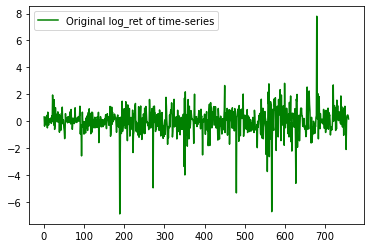

In [35]:
# plot the original time-series

rmg["log return"].plot(color = 'green', label = 'Original log_ret of time-series')
plt.legend(loc = 'upper left')

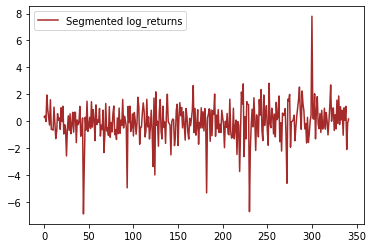

In [22]:
# plot the segmented time-series at t = 0.1
final_segments.plot(color = "brown", label = "Segmented log_return of time-series")
plt.legend(loc = 'upper left')
plt.show()

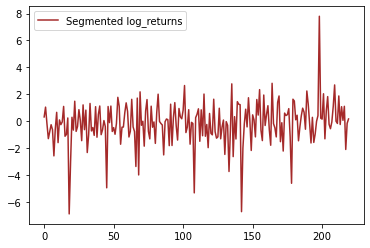

In [29]:
# plot the segmented time-series at t = 0.2
final_segments.plot(color = "brown", label = "Segmented log_return of time-series")
plt.legend(loc = 'upper left')
plt.show()

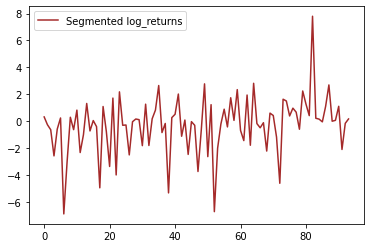

In [36]:
# plot the segmented time-series at t = 0.4
final_segments.plot(color = "brown", label = "Segmented log_return of time-series")
plt.legend(loc = 'upper left')
plt.show()